In [1]:
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''

In [2]:
run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar -l")

'avrora batik eclipse fop h2 jython luindex lusearch lusearch-fix pmd sunflow tomcat tradebeans tradesoap xalan\nMy log: initialize /tmp/fileRzJgYa, this=0x7f4110078970 with dump_freq=0\n'

In [88]:
# Functional workloads
dacapo_workloads = ['sunflow', 'pmd', 'avrora', 'fop', 'luindex', 'lusearch', 'lusearch-fix']

# Commands to run
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
# ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=0 -jar ~/research_jvm/benchmarks/renaissance-gpl-0.14.2.jar -r 1 future-genetic

In [89]:
# run_cmd("~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=10 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow")

In [3]:
run_cmd("find /tmp/ -maxdepth 1 -size +100b -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")

''

In [5]:
# logs reader

import datetime
import os
import sys

class ObjectCnt:
    def __init__(self, **kwargs) -> None:
        self.age = 0
        self.__dict__.update(kwargs)

    def __repr__(self):
        return "ObjectCnt(thread=%d, cls=%s, ptr='%s', cnt=%d, %s, size=%d, typ='%s', age=%d)" % (
            self.thread,
            self.cls,
            self.ptr,
            self.cnt,
            '' if self.length is None else ('length=%d' % self.length),
            self.size,
            self.typ,
            self.age
        )


def cur_timestamp():
    current_timestamp = datetime.datetime.now()
    return current_timestamp.strftime("%Y-%m-%d %H:%M:%S")


def reverse_readline(filename, buf_size=8192):
    with open(filename, 'r') as fh:
        segment = None
        offset = 0
        fh.seek(0, os.SEEK_END)
        file_size = remaining_size = fh.tell()
        while remaining_size > 0:
            offset = min(file_size, offset + buf_size)
            fh.seek(file_size - offset)
            buffer = fh.read(min(remaining_size, buf_size))
            remaining_size -= buf_size
            lines = buffer.split('\n')

            if segment is not None:
                if buffer[-1] != '\n': lines[-1] += segment
                else: yield segment
            
            segment = lines[0]
            for index in range(len(lines) - 1, 0, -1):
                if lines[index]:
                    yield lines[index]

        if segment is not None:
            yield segment


def read_line(filename):
    with open(filename, 'r') as file:
        for line in file:
            yield line


def add_snapshot(snapshots, snap, last_n):
    snapshots.append(snap)
    if last_n and len(snapshots) > last_n:
        snapshots = snapshots[1:]
    return snapshots


def count_number_of_dumps(logfile):
    snapshots_cnt = 0
    file_lines = reverse_readline(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            snapshots_cnt += 1

    return snapshots_cnt


def read_logs(logfile, last_n = None, verbose=False, reversed=False, generator=True):
    print(locals())
    if last_n is None: last_n = sys.maxsize
    snapshots = []
    cur_dict = set()
    snapshots_cnt = 0

    file_lines = reverse_readline(logfile) if reversed else read_line(logfile)
    for line in file_lines:
        line = line.strip()
        if not line: continue

        if 'Dump Snapshot' in line:
            if len(cur_dict) == 0: continue

            snapshots_cnt += 1

            if generator:
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
                if snapshots_cnt == last_n:
                    break
            else:
                snapshots = add_snapshot(snapshots, cur_dict, last_n)
                if reversed and len(snapshots) == last_n:
                    break
            
            cur_dict = set()
        elif 'Skipping Snapshot' not in line:
            # My log: th=172166293241342555, class=[B, ptr=0x60d1df368, cnt=64
            assert 'My log' in line, ('unexpected line format for ' + line)
            parts = line.split(', ')

            th_str = parts[0]
            if th_str.startswith('My log array:'): typ = 'array'
            elif th_str.startswith('My log obj:'): typ = 'object'
            else: assert False, ('unexpected log format for ' + th_str)

            cnt = int(parts[3][len('cnt='):])
            cnt, age = (cnt & 0x0FFFFFFF), (cnt >> 28)
            tup = ObjectCnt(
                thread = int(th_str[th_str.find('th=') + len('th='):]),
                cls = parts[1][len('class='):],
                ptr = parts[2][len('ptr='):],
                cnt = cnt,
                age = age,
                length = (None if typ == 'object' else int(parts[-2][len('len='):])),
                size = int(parts[-1][len('size='):]),
                typ = typ)
            
            cur_dict.add(tup)

    if len(cur_dict) > 0:
        if generator:
            if snapshots_cnt != last_n:
                snapshots_cnt += 1
                if verbose:
                    idx = -snapshots_cnt if reversed else (snapshots_cnt - 1)
                    print('Snapshot #%d with size=%d' % (idx, len(cur_dict)))
                yield cur_dict
        else:
            snapshots = add_snapshot(snapshots, cur_dict, last_n)

    if reversed and not generator:
        snapshots = snapshots[::-1]

    # print(snapshots)
    if verbose:
        print(cur_timestamp(), 'Got %d snapshots for the file=%s' % (snapshots_cnt, logfile))
        if not generator:
            for idx, snap in enumerate(snapshots):
                print('Snapshot #%d with size=%d' % (idx, len(snap)))

    if not generator:
        return snapshots

In [195]:
# logs/images saver

import matplotlib.backends.backend_pdf
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from math import floor


def compute_bins(access_counts, num_bins, dynamic_bins_size=True):
    if dynamic_bins_size:
        # Calculate bin edges based on quantiles
        # lower_percentiles = np.linspace(0, 90, num_bins // 3 + 1)
        # higher_percentiles = np.linspace(90, 100, num_bins - (num_bins // 3))
        # bin_edges = np.percentile(access_counts, np.concatenate([lower_percentiles, higher_percentiles]))
        # bin_edges = np.percentile(access_counts, np.linspace(0, 100, num_bins + 1))
        res = pd.qcut(access_counts, q = num_bins, duplicates='drop')
        bin_edges = []
        for category in res.categories:
            assert category.closed == 'right', category
            bin_edges.append(category.left)
        bin_edges.append(category.right)

        mask = (access_counts > bin_edges[-2]) & (access_counts <= bin_edges[-1])
        last_counts = access_counts[mask]

        extra_res = pd.qcut(last_counts, q = num_bins, duplicates='drop')
        bin_edges = bin_edges[:-2]
        for category in extra_res.categories:
            assert category.closed == 'right', category
            bin_edges.append(category.left)
        bin_edges.append(category.right)
    else:
        bin_edges = np.histogram_bin_edges(access_counts, bins=num_bins)

    return bin_edges


def plot_print_text(file, text_output):
    if file:
        plt.figure(figsize=(23, 6))
        plt.text(0.1, 0.5, text_output, fontsize=12, ha='left', va='center')
        plt.axis('off')
        file.savefig(plt.gcf())
        plt.close()
    else:
        print(text_output)


def print_size_count_bins(file, original_objects, access_counts, object_sizes, bin_edges, num_bins, display_iteration, group_by_sizes=True):
    total_object_count = len(original_objects)/1000.0
    total_object_size = sum(obj.size for obj in original_objects)/(1024*1024)

    # Calculate the total size and object count for each bin
    total_sizes = np.zeros(num_bins, dtype=int)
    total_object_counts = np.zeros(num_bins, dtype=int)
    
    for i in range(num_bins):
        mask = (access_counts > bin_edges[i]) & (access_counts <= bin_edges[i + 1])
        total_sizes[i] = np.sum(object_sizes[mask])/1024.0
        total_object_counts[i] = np.sum(mask)/1000.0
    
    if group_by_sizes: y_axis = total_sizes
    else: y_axis = total_object_counts

    # Display the histogram\n",
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    plt.bar(range(num_bins), y_axis, width=0.8, align='center')
    plt.xlabel("Bins of Access Counts")
    
    if group_by_sizes: plt.ylabel("Size of Objects, Kb")
    else: plt.ylabel("Number of Objects, K")
    plt.title("Histogram of Objects by Access Counts %s" % display_iteration)
    plt.xticks(range(num_bins), [f"{floor(bin_edges[i])}" for i in range(num_bins)])
    plt.grid(axis='y')
    plt.yscale('log')
    
    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Display the total number/size for each bin
    text_output = "Total stats for each bin %s:\n" % display_iteration
    text_output += f"Number of non-array objects: ~{round(sum(total_object_counts), 2)} K, Total: ~{round(total_object_count, 2)} K\n"
    text_output += f"Size of non-array objects: ~{round(sum(total_sizes)/1024.0, 2)} Mb, Total: ~{round(total_object_size, 2)} Mb\n"
    for i in range(num_bins):
        text_output += f"Bin ({floor(bin_edges[i])}, {floor(bin_edges[i + 1])}]: {round(total_object_counts[i], 2)}K objects, {round(total_sizes[i], 2)} Kb\n"

    plot_print_text(file, text_output)


def print_age_bins(file, objects, access_counts, bin_edges, num_bins, display_iteration):
    ages = np.array([obj.age for obj in objects])
    age_groups = np.unique([obj.age for obj in objects])
    age_proportions = np.zeros((num_bins, len(age_groups)))


    for i in range(num_bins):
        # Calculate mask for each bin
        mask = (access_counts > bin_edges[i]) & (access_counts <= bin_edges[i + 1])
        # Apply mask to filter objects
        bin_ages = ages[mask]
        total_objects_in_bin = np.sum(mask)  # Count of objects in this specific bin
        
        for j, age in enumerate(age_groups):
            age_count = np.sum(bin_ages == age)
            age_proportions[i, j] = (age_count / total_objects_in_bin) if total_objects_in_bin else 0
    
    # Display the histogram with proportions of objects in age groups
    plt.figure(figsize=(23, 6))
    colors = plt.cm.get_cmap('tab20', len(age_groups))  # Choose a colormap

    bottom = np.zeros(num_bins)
    for j in range(len(age_groups)):
        plt.bar(range(num_bins), age_proportions[:, j], width=0.8, align='center', label=f'Age: {age_groups[j]}', color=colors(j), bottom=bottom)
        bottom += age_proportions[:, j]

    plt.xlabel("Bins of Access Counts")
    plt.ylabel("Proportion of Objects by Age Group")
    plt.title("Histogram of bins of objects with age groups %s" % display_iteration)
    plt.xticks(range(num_bins), [f"{int(bin_edges[i])}" for i in range(num_bins)])
    plt.grid(axis='y')
    plt.legend()
        
    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Print age proportions for each bin
    text_output = "Age proportions for each bin %s:\n" % display_iteration
    for i in range(num_bins):
        ages = [(age, round(age_proportions[i, j] * 100, 2)) for j, age in enumerate(age_groups) if age_proportions[i, j] != 0]
        ages.sort(key=lambda x: x[1], reverse=True)
        text_output += f"Bin ({floor(bin_edges[i])},{floor(bin_edges[i + 1])}], Age-Proportions: {ages}\n"
    
    plot_print_text(file, text_output)


def print_cumulative_graph_bins(file, access_counts, object_sizes, bin_edges, num_bins, display_iteration):
    # Calculate the cumulative size for each unique access count
    unique_access_counts = np.unique(access_counts)
    cumulative_sizes = []

    for count in unique_access_counts:
        mask = (access_counts <= count)
        cumulative_sizes.append(round(np.sum(object_sizes[mask])/(1024.0*1024), 2))

    total_size = sum(object_sizes)/(1024.0*1024.0)

    # Step 2: Display the cumulative sizes
    plt.figure(figsize=(23, 6))  # Adjust figure size as needed
    plt.plot(unique_access_counts, cumulative_sizes, marker='o')

    # Adding dots with dashes for specific bin_edges
    print_edges = bin_edges[1:]
    bin_sizes = []
    for edge in print_edges:
        # Calculate mask for each bin
        mask = access_counts <= edge
        bin_sizes.append(np.sum(object_sizes[mask]/(1024.0*1024.0)))

    plt.plot(print_edges, [round(bin_size, 2) for bin_size in bin_sizes], 'o', color='red', label='Bin Edges with Dashes')
    for edge in print_edges:
        plt.axvline(x=edge, color='red', linestyle='--')

    plt.xlabel("Access Count")
    plt.ylabel("Cumulative Size of Objects, Mb")
    plt.title("Cumulative Size of Objects by Access Count%s" % display_iteration)
    plt.grid()
    plt.xscale('log')
    plt.show()

    if file:
        file.savefig(plt.gcf())
        plt.close()
    else:
        plt.show()

    # Display the total size of objects for each access count
    text_output = "Cumulative Size for bins Access Counts %s:\n" % display_iteration
    for i in range(num_bins):
        text_output += f"Bin (<{floor(bin_edges[i + 1])}]: {round(bin_sizes[i], 2)} Mb, {round(bin_sizes[i]*100.0/total_size, 2)}%\n"

    plot_print_text(file, text_output)


def display_freq_bins(objects, group_by_sizes=True, file=None, init_file=None, iteration=None):
    original_objects = objects
    # Extract the access counts and sizes from the object counts
    objects = list(obj for obj in objects if obj.typ != 'array')
    access_counts = np.array([obj.cnt for obj in objects])
    object_sizes = np.array([obj.size for obj in objects])

    # Step 1: Create bins to group the access counts automatically
    bin_edges = compute_bins(access_counts, num_bins=10)
    num_bins = len(bin_edges) - 1

    display_iteration = ' #' + str(iteration) if iteration is not None else ''

    if init_file:
        file = matplotlib.backends.backend_pdf.PdfPages(init_file) # /tmp/output.pdf

    # Step 2: print_size_count_bins
    print_size_count_bins(file, original_objects, access_counts, object_sizes, bin_edges, num_bins, display_iteration)

    # Step 3: print_age_bins
    print_age_bins(file, objects, access_counts, bin_edges, num_bins, display_iteration)

    # Step 4: print_cumulative_graph_bins
    print_cumulative_graph_bins(file, access_counts, object_sizes, bin_edges, num_bins, display_iteration)

    if init_file:
        file.close()


def replace_extension(file_path, new_extension):
    base_path, _ = os.path.splitext(file_path)
    new_file_path = base_path + new_extension
    return new_file_path


def process_store_dump(file, last_n, reversed=False):
    snapshots = read_logs(file, last_n=last_n, verbose=True)

    new_file_path = replace_extension(file, '.pdf')
    pdf = matplotlib.backends.backend_pdf.PdfPages(new_file_path)
    for idx, snap in enumerate(read_logs(file, last_n=last_n, verbose=True, generator=True, reversed=reversed)):
        if reversed: idx = - (idx + 1)
        display_freq_bins(snap, file=pdf, iteration=idx)
    pdf.close()
    return snapshots

In [89]:
file = '/home/savitar/research_jvm/results/sunflow/run1/dump_fileJd4Cpg'
snapshots = list(read_logs(file, verbose=True))
# display_freq_bins(snapshots[1], init_file='/tmp/output.pdf')

{'logfile': '/home/savitar/research_jvm/results/sunflow/run1/dump_fileJd4Cpg', 'last_n': None, 'verbose': True, 'reversed': False, 'generator': True}
Snapshot #0 with size=23268
Snapshot #1 with size=57902
Snapshot #2 with size=176913
Snapshot #3 with size=186755
Snapshot #4 with size=212709
Snapshot #5 with size=216614
Snapshot #6 with size=225552
Snapshot #7 with size=216023
Snapshot #8 with size=228425
Snapshot #9 with size=228405
Snapshot #10 with size=233573
Snapshot #11 with size=233418
Snapshot #12 with size=239596
Snapshot #13 with size=235950
Snapshot #14 with size=217395
Snapshot #15 with size=225674
Snapshot #16 with size=189536
Snapshot #17 with size=153676
Snapshot #18 with size=128890
2023-08-30 14:14:18 Got 19 snapshots for the file=/home/savitar/research_jvm/results/sunflow/run1/dump_fileJd4Cpg


In [ ]:
# display_freq_bins(snapshots[1], init_file='/tmp/output.pdf')

In [116]:
objects = [obj for obj in snap for snap in snapshots if obj.age != 0 and obj.typ != 'array']
objects

[ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24, typ='object', age=7),
 ObjectCnt(thread=8526767335953163965, cls=org/sunflow/image/Color, ptr='0x60da61c18', cnt=21, , size=24

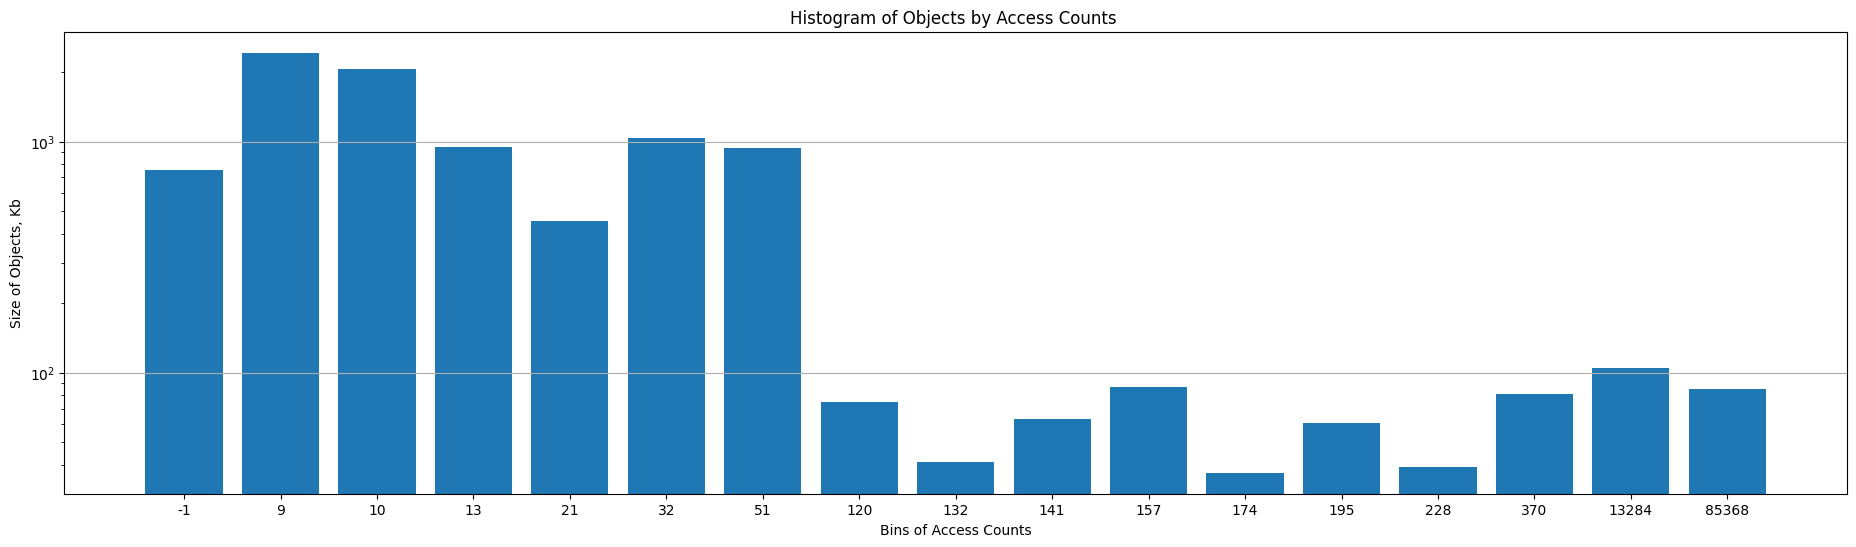

Total stats for each bin :
Number of non-array objects: ~214 K, Total: ~224.15 K
Size of non-array objects: ~9.08 Mb, Total: ~9.08 Mb
Bin (-1, 9]: 22K objects, 753 Kb
Bin (9, 10]: 44K objects, 2424 Kb
Bin (10, 13]: 38K objects, 2062 Kb
Bin (13, 21]: 39K objects, 951 Kb
Bin (21, 32]: 11K objects, 454 Kb
Bin (32, 51]: 22K objects, 1042 Kb
Bin (51, 120]: 25K objects, 934 Kb
Bin (120, 132]: 2K objects, 75 Kb
Bin (132, 141]: 1K objects, 41 Kb
Bin (141, 157]: 1K objects, 63 Kb
Bin (157, 174]: 2K objects, 87 Kb
Bin (174, 195]: 1K objects, 37 Kb
Bin (195, 228]: 2K objects, 61 Kb
Bin (228, 370]: 1K objects, 39 Kb
Bin (370, 13284]: 1K objects, 81 Kb
Bin (13284, 85368]: 1K objects, 105 Kb
Bin (85368, 139821150]: 1K objects, 85 Kb



/tmp/ipykernel_35122/370541507.py:114: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(age_groups))  # Choose a colormap


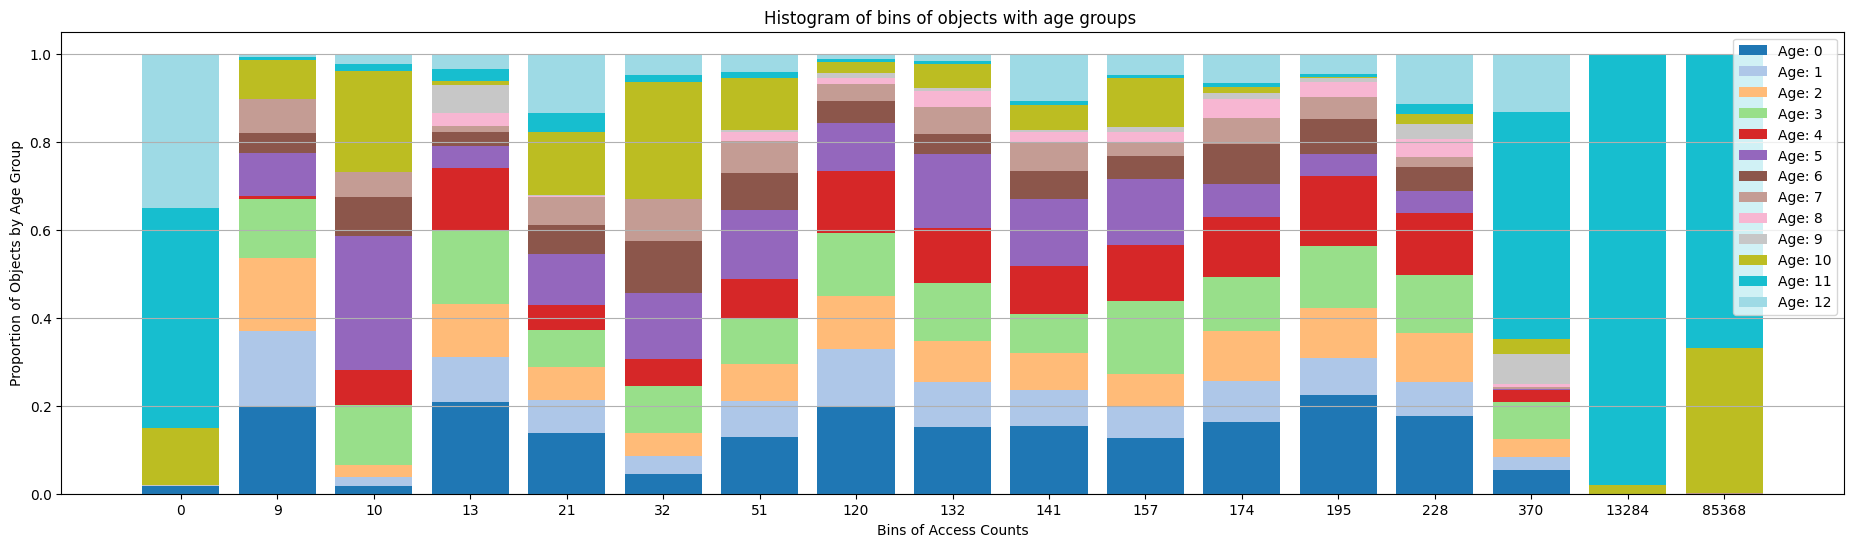

Age proportions for each bin :
Bin (-1,9], Age-Proportions: [(11, 49.98), (12, 35.16), (10, 12.96), (0, 1.84), (9, 0.05), (7, 0.01)]
Bin (9,10], Age-Proportions: [(0, 19.74), (1, 17.31), (2, 16.42), (3, 13.49), (5, 9.78), (10, 8.83), (7, 7.87), (6, 4.4), (4, 0.76), (11, 0.74), (12, 0.66)]
Bin (10,13], Age-Proportions: [(5, 30.59), (10, 22.76), (3, 13.6), (6, 8.85), (4, 7.88), (7, 5.75), (2, 2.63), (12, 2.43), (1, 2.13), (0, 1.78), (11, 1.61)]
Bin (13,21], Age-Proportions: [(0, 20.88), (3, 16.83), (4, 14.02), (2, 12.12), (1, 10.19), (9, 6.38), (5, 5.03), (12, 3.36), (6, 3.06), (8, 2.76), (11, 2.74), (7, 1.55), (10, 1.08)]
Bin (21,32], Age-Proportions: [(10, 14.41), (0, 13.73), (12, 13.4), (5, 11.58), (3, 8.52), (1, 7.66), (2, 7.42), (6, 6.67), (7, 6.23), (4, 5.53), (11, 4.38), (8, 0.4), (9, 0.08)]
Bin (32,51], Age-Proportions: [(10, 26.67), (5, 15.14), (6, 11.69), (3, 10.56), (7, 9.5), (4, 6.18), (2, 5.3), (12, 4.73), (0, 4.51), (1, 4.02), (11, 1.67), (9, 0.03), (8, 0.02)]
Bin (51,120],

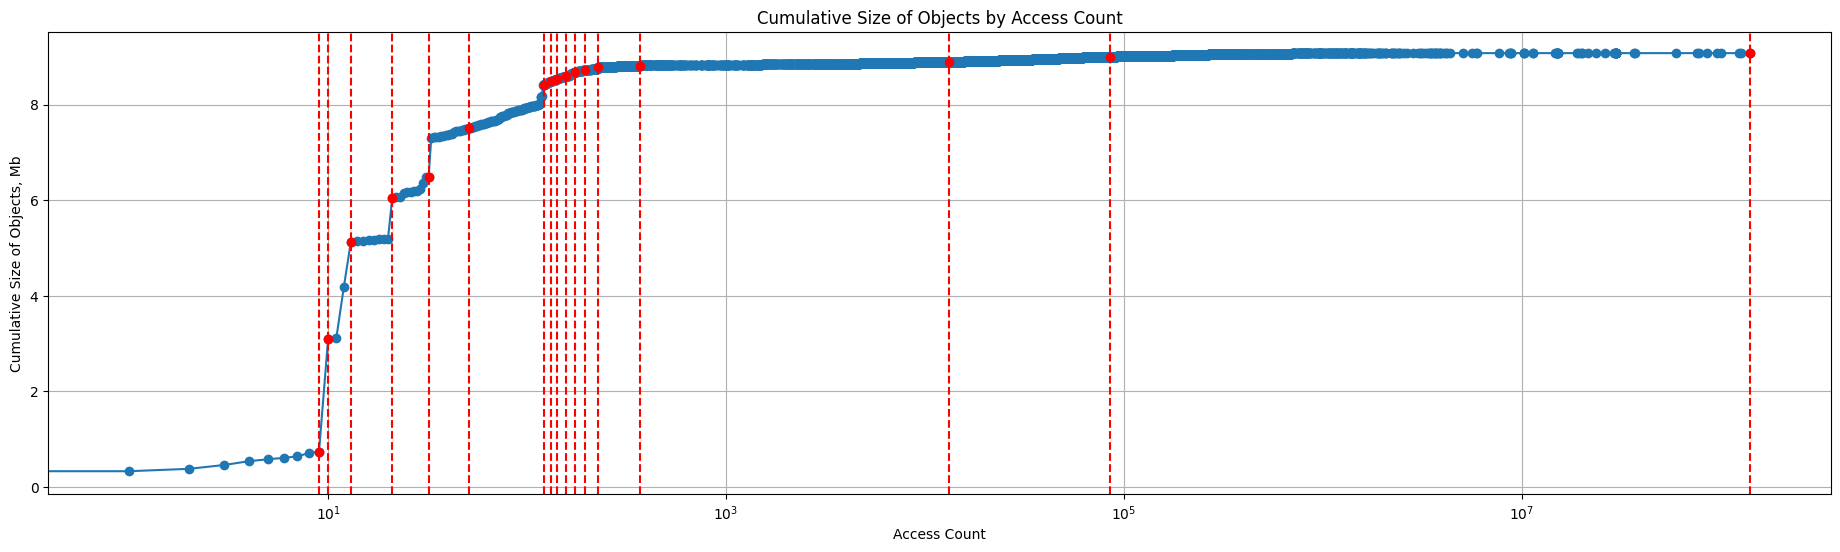

Cumulative Size for bins Access Counts :
Bin (<9]: 0.74 Mb, 8.1%
Bin (<10]: 3.1 Mb, 34.16%
Bin (<13]: 5.12 Mb, 56.33%
Bin (<21]: 6.05 Mb, 66.56%
Bin (<32]: 6.49 Mb, 71.44%
Bin (<51]: 7.51 Mb, 82.65%
Bin (<120]: 8.42 Mb, 92.7%
Bin (<132]: 8.49 Mb, 93.51%
Bin (<141]: 8.54 Mb, 93.96%
Bin (<157]: 8.6 Mb, 94.64%
Bin (<174]: 8.68 Mb, 95.59%
Bin (<195]: 8.72 Mb, 95.99%
Bin (<228]: 8.78 Mb, 96.65%
Bin (<370]: 8.82 Mb, 97.08%
Bin (<13284]: 8.9 Mb, 97.95%
Bin (<85368]: 9.0 Mb, 99.08%
Bin (<139821150]: 9.08 Mb, 100.0%



In [196]:
snap = snapshots[12]
display_freq_bins([obj for obj in snap if obj.typ != 'array'])

In [28]:
[obj for obj in snap if obj.age > 0 and obj.typ != 'array']

[]

In [15]:
# print(bin_edges)
from collections import Counter
Counter([obj.ptr for obj in snap]).most_common()

[0.0, 2.0, 4.0, 8.0, 14.0, 18.0, 42.0, 293.0, 654.1999999999999, 80752.2, 520448.0, 3604585.0, 7078005.0, 27625363.6, 39931944.00000001, 204432256.6, 226262332.0, 268435455.0]


[('0x60d41baa0', 1),
 ('0x60d5046b8', 1),
 ('0x60d41bac0', 1),
 ('0x60d518690', 1),
 ('0x60d2f8790', 1),
 ('0x60d52a1f8', 1),
 ('0x60d41bae0', 1),
 ('0x60d523cd8', 1),
 ('0x60d41bb28', 1),
 ('0x60d518060', 1),
 ('0x60d41bb70', 1),
 ('0x60d4fe098', 1),
 ('0x60d69f110', 1),
 ('0x60d508730', 1),
 ('0x60d337868', 1),
 ('0x60d507c70', 1),
 ('0x60d2e2560', 1),
 ('0x60d507c90', 1),
 ('0x60d69f268', 1),
 ('0x60d4ca6f0', 1),
 ('0x60d69f2a8', 1),
 ('0x60d5259f8', 1),
 ('0x60d41bb90', 1),
 ('0x60d522d40', 1),
 ('0x60d69f248', 1),
 ('0x60d5260c0', 1),
 ('0x60d41bbb0', 1),
 ('0x60d5025e8', 1),
 ('0x60d2e5500', 1),
 ('0x60d4fb0d0', 1),
 ('0x60d41bbd0', 1),
 ('0x60d4fb050', 1),
 ('0x60d41bc18', 1),
 ('0x60d515310', 1),
 ('0x60d69f208', 1),
 ('0x60d515280', 1),
 ('0x60d3f7100', 1),
 ('0x60d504470', 1),
 ('0x60d69f288', 1),
 ('0x60d5043f0', 1),
 ('0x60d69f228', 1),
 ('0x60d520fd8', 1),
 ('0x60d41bc60', 1),
 ('0x60d520f68', 1),
 ('0x60d41bc80', 1),
 ('0x60d511c48', 1),
 ('0x60d307608', 1),
 ('0x60d511bb

In [28]:
# The flow

# Run workflow scenario - pick one of dacapo workloads and execute with run_cmd. let it be luindex
# Find files involved in GC stuff - find command with file_ greater than 100b
# Analyze each of the files to get a sequence of snapshots for each of which build a histogram of total object size for each access count bucket. Also, exclude anomaly data
# Store the results in the file in a format "benchmark/simulation/runX"
# Build for all the snapshots at this stage, but eventually we shouldn't pick more than 10
# Cleanup to remove the file* from /tmp

import os
import shutil
import subprocess

def run_cmd(command, verbose=False):
    try:
        # Execute the command in the command prompt and capture the output
        result = subprocess.run(command, shell=True, capture_output=True, text=True)

        # Check if the command was successful
        if result.returncode == 0:
            if verbose: print(result.stdout)
            return result.stdout
        else:
            print(f"Command failed with return code {result.returncode}.")
            print("Error:")
            print(result.stderr)
            return ''
    
    except Exception as e:
        print(f"Error occurred: {e}")
        return ''


OUTPUT_DIR = '/home/savitar/research_jvm/results/'


def file_is_dump(file):
    return os.path.getsize(file) > 100


def run_iteration(iter=0, run_benchmark=True, cleanup=True, last_n=100, dump_period=10, benchmark='luindex', copy_files=True):
    print(cur_timestamp(), 'Running iteration #{} with args={}'.format(iter, locals()))

    # cleanup
    if cleanup:
        print(cur_timestamp(), 'Cleanup')
        run_cmd("rm -f /tmp/file*")

    if not copy_files: run_benchmark = False
    
    if run_benchmark:
        cmd = f"~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq={dump_period} -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar {benchmark}" # sunflow
        print(cur_timestamp(), "Executing benchmark:", cmd)
        run_cmd(cmd)

    iteration_dir = os.path.join(OUTPUT_DIR, benchmark, 'run%d' % iter)

    if copy_files:
        if os.path.exists(iteration_dir):
            shutil.rmtree(iteration_dir)
        os.makedirs(iteration_dir)

        # copy all files first
        print(cur_timestamp(), 'Copying all the files to the %s' % iteration_dir)
        found_files = run_cmd("find /tmp/ -maxdepth 1 -type f -name 'file*' -exec ls -lth {} + | awk '{print $NF}'")
        copied_dump_files = []
        if found_files:
            found_files = found_files.splitlines()
            
            for file in found_files:
                is_dump = file_is_dump(file)

                basename = os.path.basename(file)
                if is_dump:
                    basename = 'dump_' + basename

                file_name = os.path.join(iteration_dir, basename)
                shutil.copy(file, file_name)

                if is_dump:
                    copied_dump_files.append(file_name)
    else:
        # pick up files from the directory
        found_files = run_cmd("find '%s' -maxdepth 1 -type f -name 'dump_*' ! -name '*.*'" % iteration_dir)
        copied_dump_files = []
        if found_files:
            copied_dump_files = found_files.splitlines()

    print(cur_timestamp(), 'Got {} files: {}'.format(len(copied_dump_files), copied_dump_files))

    # analyze dumps
    print(cur_timestamp(), 'Processing and storing %d dumps' % len(copied_dump_files))
    if copied_dump_files:
        for dump_file in copied_dump_files:
            process_store_dump(dump_file, last_n=last_n)

    print()

In [41]:
run_iteration(1, dump_period=5, benchmark='sunflow')

2023-08-25 16:07:23 Running iteration #1 with args={'iter': 1, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 5, 'benchmark': 'sunflow', 'copy_files': True}
2023-08-25 16:07:23 Cleanup
2023-08-25 16:07:23 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=5 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
2023-08-25 16:08:49 Copying all the files to the /home/savitar/research_jvm/results/sunflow/run1
2023-08-25 16:08:50 Got 1 files: ['/home/savitar/research_jvm/results/sunflow/run1/dump_fileHbAKJz']
2023-08-25 16:08:50 Processing and storing 1 dumps
{'logfile': '/home/savitar/research_jvm/results/sunflow/run1/dump_fileHbAKJz', 'last_n': 100, 'verbose': True, 'reversed': False, 'generator': True}
Snapshot #0 with size=23134


/tmp/ipykernel_847053/3072688637.py:110: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(age_groups))  # Choose a colormap


Snapshot #1 with size=57888
Snapshot #2 with size=170978
Snapshot #3 with size=194669
Snapshot #4 with size=219404
Snapshot #5 with size=215500
Snapshot #6 with size=221773
Snapshot #7 with size=221431
Snapshot #8 with size=223309
Snapshot #9 with size=237936
Snapshot #10 with size=236688
Snapshot #11 with size=231832
Snapshot #12 with size=214093
Snapshot #13 with size=187721
Snapshot #14 with size=154319
Snapshot #15 with size=91836
2023-08-25 16:09:17 Got 16 snapshots for the file=/home/savitar/research_jvm/results/sunflow/run1/dump_fileHbAKJz



In [106]:
def run_workflow(benchmark='sunflow', num=15, copy_files=True, dump_period=5, last_n=100):
    for iter in range(num):
        try:
            run_iteration(iter, last_n=last_n, dump_period=dump_period, benchmark=benchmark, copy_files=copy_files)
        except Exception as ex:
            print('Iteration failed with', ex)

In [107]:
# run_workflow()

2023-08-08 21:11:22 Running iteration #0 with args={'iter': 0, 'run_benchmark': True, 'cleanup': True, 'last_n': 100, 'dump_period': 5, 'benchmark': 'sunflow'}
2023-08-08 21:11:22 Cleanup
2023-08-08 21:11:22 Executing benchmark: ~/openj9-openjdk-jdk17/build/slowdebug/jdk/bin/java -Xgcpolicy:optthruput -Xint -Xgc:dumpObjCountFreq=5 -jar ~/research_jvm/benchmarks/dacapo-9.12-MR1-bach.jar sunflow
2023-08-08 21:12:53 Copying all the files to the /home/savitar/research_jvm/benchmarks/simulation/run0
2023-08-08 21:12:53 Processing and storing 1 dumps
2023-08-08 21:13:05 Got 15 snapshots for the file=/home/savitar/research_jvm/benchmarks/simulation/run0/dump_fileHcqN0u
Snapshot #0 with size=23134
Snapshot #1 with size=187691
Snapshot #2 with size=218939
Snapshot #3 with size=219319
Snapshot #4 with size=217985
Snapshot #5 with size=230413
Snapshot #6 with size=232232
Snapshot #7 with size=234834
Snapshot #8 with size=235543
Snapshot #9 with size=224477
Snapshot #10 with size=226907
Snapshot #